In [10]:
import os
import illustris_python as il

basePath = os.path.expanduser("~/Documents/uni/dsp/tng300/outputs")
fields = ["SubhaloMass", "SubhaloSFRinRad"]

subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)
subhalos["count"], subhalos["SubhaloMass"].shape


(np.int64(14485709), (14485709,))

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_53099/4016559389.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Total Mass [$M_\odot$]')
/tmp/ipykernel_53099/4016559389.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Star Formation Rate [$M_\odot / yr$]')


Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

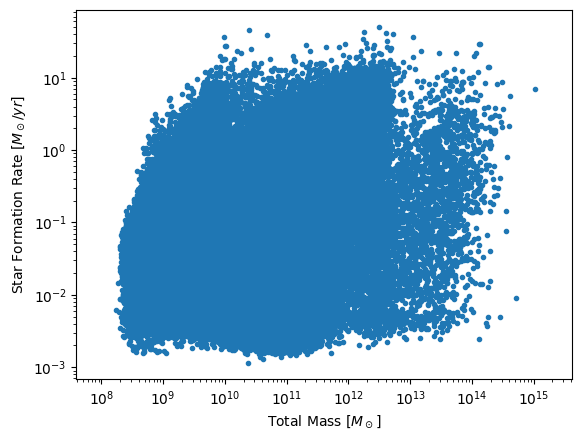

In [11]:
import matplotlib.pyplot as plt
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')